In [1]:
import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

In [2]:
from html.parser import HTMLParser
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
 # Целевой признак - число рекомендаций (лайков) статьи, 
    # приведенные в статье значения - логарифм с единицей
    # от числа рекомендаций
path_to_train = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/train.json'
path_to_data = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/'


In [4]:
!ls -l $path_to_data

итого 4144740
-rw-rw-r-- 1 misha misha     874228 дек 11 15:44 first_ridge3.csv
-rw-rw-r-- 1 misha misha     870760 дек 11 18:07 first_ridge4.csv
-rw-rw-r-- 1 misha misha     870760 дек 11 18:07 first_ridge.csv
-rw-rw-r-- 1 misha misha     526712 дек 10 23:40 MediumArticle_baseline_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     848234 дек 11 18:31 MediumArticle_Ridge_baseline_tf-idf_ubuntu.ipynb
-rw-rw-r-- 1 misha misha      41774 дек 11 18:35 MediumArticle_Ridge_baseline_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     884217 ноя 29  2019 sample_submission.csv
-rw-rw-r-- 1 misha misha 1156020029 ноя 29  2019 test.json
-rw-rw-r-- 1 misha misha     555138 ноя 29  2019 test_log1p_recommends.csv
-rw-rw-r-- 1 misha misha  347316113 дек 11 15:37 test_raw_content.txt
-rw-rw-r-- 1 misha misha 2086185062 ноя 29  2019 train.json
-rw-rw-r-- 1 misha misha     912544 ноя 29  2019 train_log1p_recommends.csv
-rw-rw-r-- 1 misha misha  648268208 дек 11 15:37 train_raw_content.txt


#### Функция для чтения JSON файла (без сбоев при исп. escape-символов)

In [5]:


def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result



#### Функция, берущая json файл, убирающая html-теги, и оставляющая только текст статьи

In [6]:


def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list



In [7]:
%%time
train_raw_content = preprocess(path_to_inp_json_file=\
                               os.path.join(path_to_data, 
                                                'train.json'))


<ipython-input-6-2e360253a763>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):



CPU times: user 2min 58s, sys: 1.84 s, total: 3min
Wall time: 2min 59s


In [8]:
%%time
test_raw_content = preprocess(path_to_inp_json_file=\
                               os.path.join(path_to_data, 
                                                'test.json'))


<ipython-input-6-2e360253a763>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):



CPU times: user 1min 48s, sys: 1.3 s, total: 1min 49s
Wall time: 1min 49s


#### Конвертируем набор текста в матрицу признаков

In [9]:
# Конвертируем набор текста в матрицу токенов
# Ограничим число признаков 100000
cv = CountVectorizer(max_features=50000)

In [10]:
%%time
# подаем на вход ему файлы train\test_raw_content.txt
X_train = cv.fit_transform(train_raw_content)
X_test = cv.transform(test_raw_content)

CPU times: user 1min 45s, sys: 1.06 s, total: 1min 46s
Wall time: 1min 46s


In [11]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

#### Считываем метки (кол-во рекомендаций)

In [12]:
y_train = pd.read_csv(os.path.join(path_to_data, 'train_log1p_recommends.csv'), index_col='id')
#y_test = pd.read_csv(os.path.join(path_to_data, 'test_log1p_recommends.csv'), index_col='id')
y_train = y_train['log_recommends'].values
#y_test = y_test['log_recommends'].values

#### Построим распределение целевой переменной

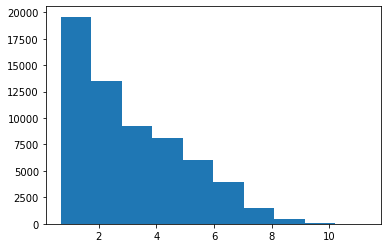

In [13]:
plt.hist(y_train);

In [14]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, train_size=0.7)

In [15]:
?train_test_split

#### Обучим Ridge-регрессию на данных

In [16]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(random_state=17)

In [17]:
X_tr.shape, y_tr.shape

((43619, 50000), (43619,))

In [18]:
%%time 
ridge_model.fit(X_tr, y_tr)

CPU times: user 1h 27min 40s, sys: 3h 6min 2s, total: 4h 33min 43s
Wall time: 39min 19s


Ridge(random_state=17)

In [19]:
ridge_07test_pred = ridge_model.predict(X_te)

In [20]:
ridge_07test_pred

array([-2.09925116,  5.18420058, -0.61778244, ...,  7.20231755,
        3.90425259,  5.48130298])

In [21]:
mean_absolute_error(y_te, ridge_07test_pred)

3.643420490581846

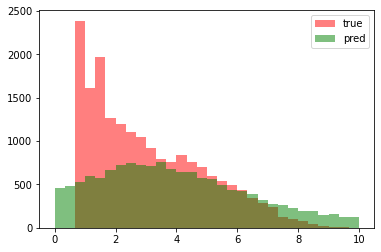

In [22]:
plt.hist(y_te, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_07test_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();



#### Обучаемся и делаем прогноз на тестовой выборке

In [23]:
%%time
ridge_model.fit(X_train, y_train)
ridge_test_pred = ridge_model.predict(X_test)

CPU times: user 14min 15s, sys: 30min 31s, total: 44min 47s
Wall time: 5min 39s


In [24]:
print([i for i in ridge_test_pred])

[7.3739447716349975, 2.761345574614658, 5.335852959492861, -1.9487157881759605, 7.112359600609977, 8.182362263897332, 2.950890275058664, 4.766676691532291, 2.7772132496014494, 6.336536298940537, 4.317549673245727, 6.25850203784152, 6.488250595215943, 5.270939949456487, 6.571918048143022, 8.025756629088642, 6.089378614995459, 6.742024195033132, 4.96581507902579, 4.891320660512651, 7.128593432965442, 7.494228925786057, 7.733045025502686, 6.423691320099972, 2.653370208492573, 4.944385831268936, 6.671123805292607, 3.103694734666183, 5.56965270391361, 0.4549604481111722, 6.166543590831367, 3.632375185901828, 7.017882297898952, 1.1894681184852742, 4.496233584468387, 4.872617055600226, 7.316269663885483, 7.680142238822664, 11.867904687609618, 4.714973740438023, 0.5471436188517181, -0.21442610485033997, 5.872919423761069, -0.4254078860469588, 4.830964285005052, 3.931717943883047, 4.678970075294349, 3.1775638569899143, 4.3079864564960175, 0.16077160656356781, 3.7557050972114783, 6.6766670037541

In [25]:
def write_submission(pred, filename, path_to_sample=os.path.join(path_to_data, 'sample_submission.csv')):
    sub = pd.read_csv(path_to_sample, index_col='id')
    sub['log_recommends'] = pred
    sub.to_csv(filename)

In [26]:
write_submission(ridge_test_pred, os.path.join(path_to_data, 'first_ridge3.csv'))

#### Итоговый результат Kaggle:

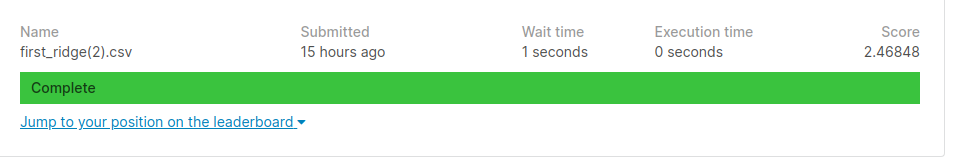